# 8.902 Astrophysics II Final Project: Dark Matter Halos
#### Group: Ethan Marx, Geoffrey Mo, Haochen Wang, Rahul Jayaraman

In this project, we use the GADGET-2 N-body cosmological simulation to create a simulation of the universe in a small cubic region. We then determine the structure of the dark matter halos within this toy universe and then are asked to analyze the most massive halo. For reasons that will be explained later, we actually analyzed the second most-massive halo. We then fit the NFW profile and identify the relevant parameters.

### Imports and Data Loading

In [1]:
import matplotlib.pyplot as plt
import readsnapGadget2 as snap
import numpy as np
import pickle
from copy import copy
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# read the simulation result
snapnum = 95
filename = f"data/snapshot_{str(snapnum).zfill(3)}"
head = snap.snapshot_header(filename) # read the header
pos = snap.read_block(filename, "POS ")
mass = snap.read_block(filename, "MASS")

# create copy of particle locations. It stores the locations of particles that have not been grouped yet.
particles = pos.copy()
n_particles = len(pos)
boxsize = head.boxsize 
link_len = 0.2*(boxsize**3/n_particles)**(1/3) # kpc formula: 0.2*(V/N)^(1/3)

assert head.redshift < 1e-10 #present time
assert boxsize == 50000
assert len(set(mass)) == 1 #do all DM particles have the same mass?

#Below set of code assumes we have already run friends-of-friends and loads those results
load_from_pkl = True 
if load_from_pkl:
    groups = pickle.load(open( "groups.pickle", "rb" ))
    sizes = pickle.load(open( "sizes.pickle", "rb" ))
    groupsize_max = int(np.amax(np.fromiter(sizes.values(), dtype=float)))
    biggest_halo_mass = groupsize_max*mass[0]
    print(f"Some information about the DM halos:\n\
    The total number of particles is {n_particles}\n\
    The total number of groups is {len(groups)}, with a linking length of {link_len:.2f} kpc\n\
    The largest group has a size of {groupsize_max} with a mass of {biggest_halo_mass} x 10^10 solar masses")

Some information about the DM halos:
    The total number of particles is 262144
    The total number of groups is 134021, with a linking length of 156.25 kpc
    The largest group has a size of 2284 with a mass of 8161.522034645081 x 10^10 solar masses


### Friend-of-friends algorithm
Because we already ran the friends-of-friends algorithm, we loaded the information about the dark matter particles in our toy universe above. Below, we have implemented the friends-of-friends algorithm. The first piece of code is a distance function that returns the distance from a particular particle to *all other particles* in the list. We have accounted for periodic boundary conditions, so the box "wraps around." This is done because in a larger universe, an adjacent cube of particles would affect the particles in this cell, but that would not be accounted for without periodic boundary conditions.

The friend-of-friends algorithm identifies the set of particles that are closer than the linking length (above) to the initial particle. These particles are then isolated into a group, which is then traversed in order to find "friends of friends" (FoFs, i.e. other particles whose distance from any of the particles in this group is less than the linking length). These FoFs are then added to the group, and then the loop traverses these newly-added particles as well. This continues until there are no more particles to be grouped, which means that we have identified all DM particles that form a particular halo.

In [4]:
# This calculates the 3d distance between the selected particle and all the other particles that have not been grouped
def distance(other_particles, particle):
    # get the differece in x, y, z coordinates
    dx = other_particles[:, 0] - particle[0]
    dy = other_particles[:, 1] - particle[1]
    dz = other_particles[:, 2] - particle[2]
    # account for periodic boundary conditions
    dx[dx > boxsize/2] = boxsize - dx[dx > boxsize/2]
    dy[dy > boxsize/2] = boxsize - dy[dy > boxsize/2]
    dz[dz > boxsize/2] = boxsize - dz[dz > boxsize/2]
    
    dist = (dx**2 + dy**2 + dz**2)**0.5
    return dist

groups = {} # Positions of halo particles
sizes = {} # size of the halo (# of particles in it)
group_id = 0 # initial group id
pbar = tqdm(total=len(particles)) # progress bar

while len(particles) > 0:
    part = particles[0] # location of first particle
    dists = distance(particles, part)
    
    # add close-enough particles to the current group, and remove them
    mask = np.where(dists < link_len)[0]
    groups[group_id] = particles[mask]
    particles = np.delete(particles, mask, axis=0)
    
    '''Find the friends of friends of part'''
    pointer = 1 # for whom we are looking for more friends? the index of elements in groups[group_id]
    num_friends = len(groups[group_id])
    while pointer < num_friends:
        # get position and distances of the friend being considered, and which are close enough
        part_friend = groups[group_id][pointer]
        dists = distance(particles, part_friend)
        mask = np.where(dists < link_len)[0]
        
        # if we found friends of that friend, add to current group and delete from particle list
        if len(mask) > 0:
            friends_of_friend = particles[mask]
            groups[group_id] = np.concatenate([groups[group_id], friends_of_friend])
            particles = np.delete(particles, mask, axis=0)

        pointer +=1
        num_friends = len(groups[group_id])
    
    '''Current group completed. Move on to the next group'''
    sizes[group_id] = len(groups[group_id]) 
    group_id += 1
    pbar.update(1)
    
pickle.dump(groups, open( "groups.pickle", "wb"))
pickle.dump(sizes, open("sizes.pickle", "wb"))

### Checking the output of the algorithm
We want to make sure that there's a variety of sizes of haloes and that the friend of friends algorithm correctly identified halos. To this end, we plot every halo above a certain size (threshold of 30 DM particles) in a 3-D coordinate system. Each group gets a different color.  

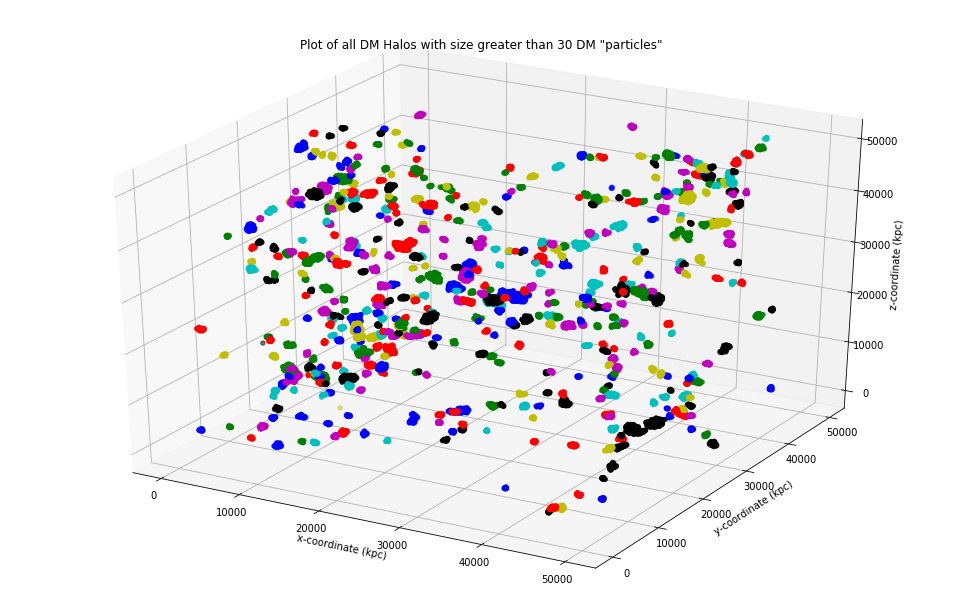

In [10]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
xs, ys, zs, col = [], [], [], []
for i in range(len(groups)):
    if sizes[i] > 30:
        for j in range(sizes[i]):
            xs += [groups[i][j][0]]
            ys += [groups[i][j][1]]
            zs += [groups[i][j][2]]
            col += [colorlist[i%7]]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='.', s=75, c=col)
ax.set_xlabel("x-coordinate (kpc)")
ax.set_ylabel("y-coordinate (kpc)")
ax.set_zlabel("z-coordinate (kpc)")
ax.set_title("Plot of all DM Halos with size greater than 30 DM \"particles\"")
plt.show()

Great, we see a variety of halo sizes and also find that haloes that are far enough away from each other are not associated with each other. This is in line with what we expect, so we push through and take a deep dive into an individual halo.

## Finding the density profile of the largest halo

Now, we want to identify the largest halo and study its density profile. To do so, we use the one we identified with the largest size and identify its center of mass. We then calculate the distance of each DM particle from the center of mass of the halo and bin them logarithmically. We expect the DM halo to be more clumped toward the center, and sparser as we go radially outward, so we bin in logarithmic space. We then calculate the volume of the spherical shell corresponding to the bin and then plot this against the radial distance. Based on our knowledge from class, the NFW profile modeling DM haloes should decrease with increasing radii (_somewhat_ linearly on a log-log plot), so let's see what happens when we do this...

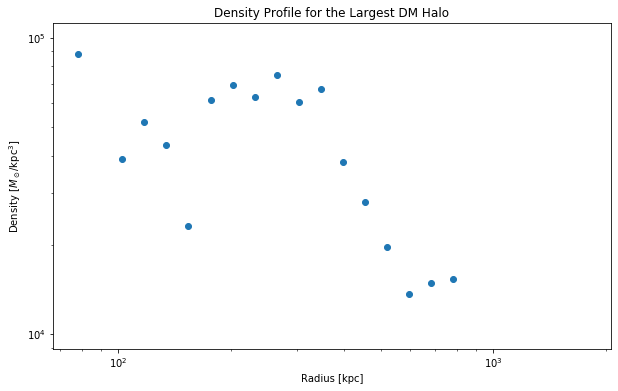

In [6]:
largest_group = groups[np.argmax(np.fromiter(sizes.values(), dtype=float))]
com_largest_halo = np.mean(largest_group, axis=0)
dists_from_com = [np.linalg.norm(np.array(k) - com_largest_halo) for k in largest_group]

closest_dist, largest_dist = min(dists_from_com), max(dists_from_com)
bins = np.logspace(np.log10(closest_dist), np.log10(largest_dist), num=25)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins])
sph_shell_vols = np.diff(sphere_vols)
cts, _ = np.histogram(dists_from_com, bins=bins)
assert len(sph_shell_vols) == len(cts)
y_axis = cts*mass[0]*1e10/sph_shell_vols
bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])

plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, y_axis)
plt.title("Density Profile for the Largest DM Halo")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [kpc]");
plt.ylabel("Density [$M_\odot/\mathrm{kpc}^3$]");

Hmm, this plot looks fishy -- it's weirdly bimodal, and not like the monotonically-decreasing NFW profile at all. Let's plot the DM particles and the COM to see what's going on, and whether this is a reasonable profile to expect for this particular DM halo.

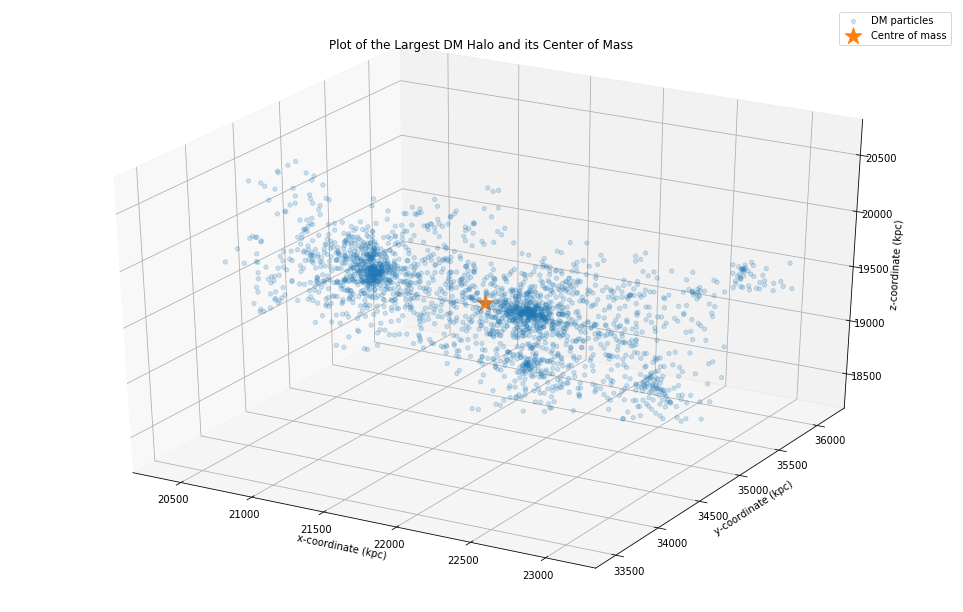

In [11]:
fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(largest_group[:,0], largest_group[:,1], largest_group[:,2],marker='.', s=75, alpha=0.2, label='DM particles')
ax.scatter(com_largest_halo[0], com_largest_halo[1], com_largest_halo[2], marker='*', s=300, label='Centre of mass')
ax.set_xlabel("x-coordinate (kpc)")
ax.set_ylabel("y-coordinate (kpc)")
ax.set_zlabel("z-coordinate (kpc)")
ax.set_title("Plot of the Largest DM Halo and its Center of Mass")
plt.legend();
plt.show()

Indeed, this was a weird halo. It seems like we've caught the two halos in the middle of a merger, which would make sense -- the spherical density profile is bimodal, and cannot be modeled by the NFW profile until far into the future. Hopefully the second-largest halo will yield more fruit. To make sure we're not barking up the wrong tree, we will plot the DM particles and the COM before diving into the density profile analysis.

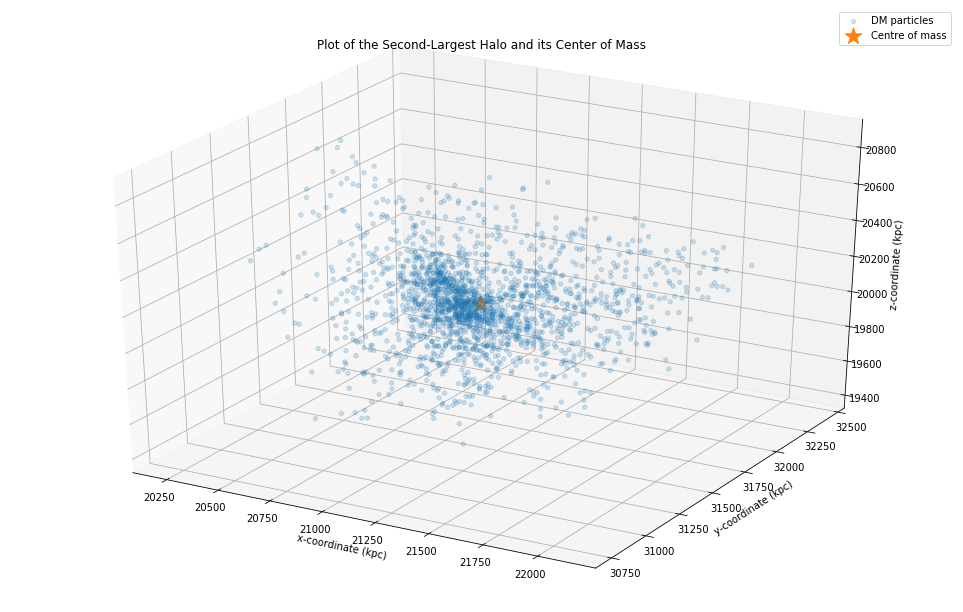

In [12]:
second_largest_group = groups[np.argsort(np.fromiter(sizes.values(), dtype=float))[-2]]
com_second_largest_halo = np.mean(second_largest_group, axis=0)
dists_from_com_2 = [np.linalg.norm(np.array(k) - com_second_largest_halo) for k in second_largest_group]

fig = plt.figure(figsize=(17, 11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(second_largest_group[:,0], second_largest_group[:,1], second_largest_group[:,2],marker='.', s=75, alpha=0.2, label='DM particles')
ax.scatter(com_second_largest_halo[0], com_second_largest_halo[1], com_second_largest_halo[2], marker='*', s=300, label='Centre of mass')
ax.set_xlabel("x-coordinate (kpc)")
ax.set_ylabel("y-coordinate (kpc)")
ax.set_zlabel("z-coordinate (kpc)")
ax.set_title("Plot of the Second-Largest Halo and its Center of Mass")
plt.legend();
plt.show()

This looks more like a typical DM halo, which we expect. We proceed to plot the spherically averaged density profile, using the technique described above.

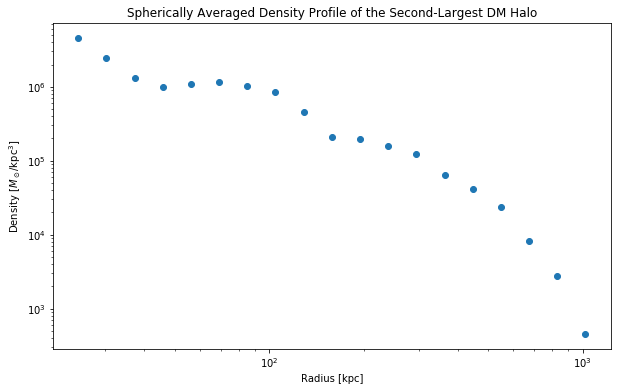

In [14]:
closest_dist_2, largest_dist_2 = min(dists_from_com_2), max(dists_from_com_2)
bins_2 = np.logspace(np.log10(closest_dist_2), np.log10(largest_dist_2), num=20)
sphere_vols = np.array([(4/3)*np.pi*radius**3 for radius in bins_2])
sph_shell_vols = np.diff(sphere_vols)
cts, bin_edges = np.histogram(dists_from_com_2, bins=bins_2)
assert len(sph_shell_vols) == len(cts)
densities = cts*mass[0]*1e10/sph_shell_vols
radii = np.array([(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])

plt.figure(figsize=(10, 6))
plt.scatter(radii, densities)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [kpc]");
plt.ylabel("Density [$M_\odot/\mathrm{kpc}^3$]");
plt.title("Spherically Averaged Density Profile of the Second-Largest DM Halo");

### Fitting to the NFW Profile
Now, we'll try to fit this radial density profile with an NFW profile. This is
\begin{align*}
\rho(r) = \frac{\rho_0}{(r/a)(1+r/a)^2}.
\end{align*}
We'll fit for both $\rho_0$ and $a$, where $a$ is the scale radius. Using scipy's curve fitting functions, we write a function that will fit the NFW profile in log space. We had issues with fitting it in linear space, which is why we made the choice to move to log space. After we identify the best-fit parameters, we will plot the data (above) with the best-fit NFW profile, and then analyze the best-fit parameters to see what they can tell us about the halo.

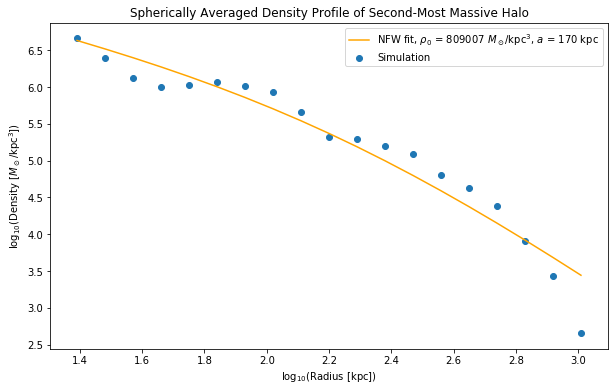

In [15]:
def log10nfw(log10r, log10rho0, log10a):
    return log10rho0 - log10r + log10a - 2*np.log10(1 + 10**(log10r)/10**(log10a))

guess_rho0 = 10**8
guess_a = 10**3
popt, pcov = curve_fit(log10nfw, np.log10(radii), np.log10(densities), p0=[np.log10(guess_rho0), np.log10(guess_a)])
fit_rho0, fit_a = 10**popt

plt.figure(figsize=(10, 6))
plt.scatter(np.log10(radii), np.log10(densities), label='Simulation')
plt.plot(np.log10(radii), log10nfw(np.log10(radii), *popt), label=rf'NFW fit, $\rho_0$ = {int(fit_rho0)} $M_\odot$/kpc$^3$, $a$ = {int(fit_a)} kpc', c='orange')
plt.xlabel("log$_{10}$(Radius [kpc])");
plt.ylabel("log$_{10}$(Density [$M_\odot/\mathrm{kpc}^3$])");
plt.legend();
plt.title("Spherically Averaged Density Profile of Second-Most Massive Halo");

This looks like a pretty decent fit. The density at $r = 0$ of the halo is $8 \times 10^5 M_\odot/\text{kpc}^3$, and decreases as we go out. The "characteristic radius" $a$ is found to be 170 kpc. We use these fit parameters to find the concentration of the halo, which is defined as $c = R_\mathrm{vir}/a$. By taking the edge of the halo to be the virial radius $R_\mathrm{vir}$, we can find the concentration of the second-most massive DM halo from our simulation.

In [16]:
concentration = radii[-1]/fit_a
print(f"The DM Halo concentration is {concentration:.2f}.")

The DM Halo concentration is 5.98.


Based on Wechsler+2002, virial concentration parameters at $a = 1$ (the present day) are between 0.1 and 10. Thus, our value of $\boxed{5.98}$ makes sense.

### Halo mass function at redshift zero
Now, we want to plot the halo mass function at present day. The halo mass function is the number density of haloes of a given mass at a given redshift, $\frac{dN}{d\log{M}}$. First, we calculate the mass of each halo and bin them. Because more massive halos are significantly rarer than less massive ones, we use logarithmic bins to account for this fact. In fact, many of the haloes we calculated using FoF contain only one DM particle -- so there is an overrepresentation toward the lower end of the mass spectrum, and logarithmic bins can take care of this.

26


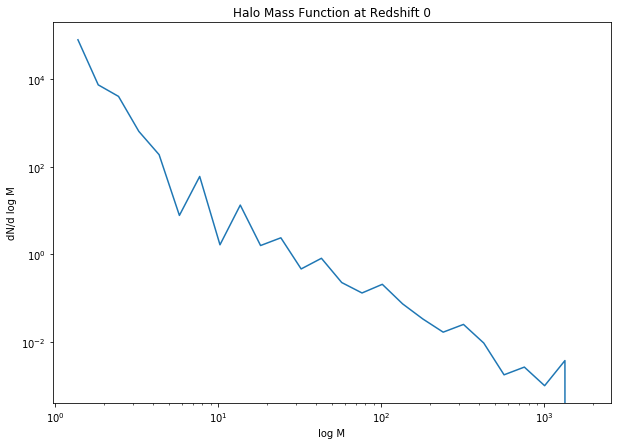

In [41]:
mass_of_halos = np.fromiter(sizes.values(), dtype=float)*mass[0]
mass_bins = np.logspace(np.log10(min(mass_of_halos)), np.log10(max(mass_of_halos)), num=28)
mass_cts, _ = np.histogram(mass_of_halos, bins=mass_bins)
mass_pts = np.array([(mass_bins[i] + mass_bins[i+1])/2 for i in range(len(mass_bins)-1)])

diff_cts = np.abs(np.diff(mass_cts))
diff_bins = np.abs(np.diff(mass_pts))

print(len(diff_bins))

plt.figure(figsize=(10, 7))
plt.plot(diff_bins, diff_cts/diff_bins)
plt.xscale('log')
plt.yscale('log')
plt.title("Halo Mass Function at Redshift 0")
plt.xlabel("log M");
plt.ylabel("dN/d log M");

This makes sense; it agrees with what is observed in Lukić+2007. As the halo becomes more massive, we would expect the number density for that particular mass to decrease. I believe that better bins are needed...

#### Works Cited

* Wechsler RH, Bullock JS, Primack JR et al. ApJ 568:52–70, 2002.
* Lukić Z, Heitmann K, Habib S et al. ApJ 671:1160Y1181, 2007.